# Benchmark LIT-PCBA
This notebook performs a performance comparison between different models using the LIT-PCBA dataset.

The models in the benchmark are:
* Our atom/surface-level ensemble (DENVIS) trained on PDBbind general set (DENVIS-G).
* Our atom/surface-level ensemble (DENVIS) trained on PDBbind refined set (DENVIS-R).
* GNINA
* DeepDTA
* Our ligand baseline trained on PDBbind refined set.

We compare AUROC, EF1 and BedROC metrics. For each model we have one group comprising multiple targets. For micro-average scores we use median (as we make no assumptions regarding distributions of metrics).

We do not perform a statistical analysis here due to the small number of targets in the dataset.

**Warning**: Due to the large size of the dataset, parsing may take a very long time (up to a few hours) and may use a significant amount of memory (up to 100G). 

In [1]:
%set_env OUTDATED_IGNORE=1  # suppress pingouing out-of-date warnings

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import json
import pingouin as pg

import ensembling
import metrics
import parsing
import postprocessing
import plotting_utils

env: OUTDATED_IGNORE=1  # suppress pingouing out-of-date warnings


# 1. Configuration

In [8]:
AVG_FUN = np.median  # Reduce function to compute averages across targets.
EF_ALPHA = 0.01 # alpha for EF metric (i.e., EF1)
BEDROC_ALPHA = 80.5 # alpha for BedROC metric (i.e, BedROC80.5)

PERFORMANCE_METRICS = ['AUROC', 'EF1', 'BEDROC80.5']
DATASET = 'LIT-PCBA'

MAIN_PATH = '../data/outputs'
PAIR_ID_COLS = ['target_id', 'target_pdb', 'ligand_id']  # Specifies a unique protein-ligand pair
REDUCE_MULTIPLE_PDBS = 'max'  # Reduce function for multiple PDB files per target-ligand pair
TARGET_PDB_CORRESPONDENCE = '../data/litpcba/lit_pcba_pdb_correspondence.json'

PATH_RESULTS = {
    'DENVIS-G': {
        'atom': os.path.join(MAIN_PATH, 'denvis_outputs', 'litpcba_main_general_atom.parquet'),
        'surface': os.path.join(MAIN_PATH, 'denvis_outputs', 'litpcba_main_general_surface.parquet'),},
    'DENVIS-R': {
        'atom': os.path.join(MAIN_PATH, 'denvis_outputs', 'litpcba_main_refined_atom.parquet'),
        'surface': os.path.join(MAIN_PATH, 'denvis_outputs', 'litpcba_main_refined_surface.parquet')},
    'Ligand bsl.': os.path.join(MAIN_PATH, 'denvis_outputs', 'litpcba_main_refined_ligand_bsl.parquet'),
    'GNINA': os.path.join(MAIN_PATH, 'gnina_outputs/litpcba', 'newdefault_CNNaffinity-max.summary'),
    'Deep DTA': os.path.join(MAIN_PATH, 'deepdta_outputs', 'litpcba_trained_pdbbind.json'),
}

# Network output aggregation kwargs for refined/general models
# General models have three outpus (Kd, Ki, IC50), refined models have two (Ki, Kd)
OUTPUT_COMBINATION_KWS = {
    'DENVIS-G': {'y_aff_weight': 0., 'y_kd_weight': 0.5, 'y_ki_weight': 0.5, 'y_ic50_weight': 0.5, 'use_clf': False, 'clf_strategy': None},
    'DENVIS-R': {'y_aff_weight': 0., 'y_kd_weight': 0.5, 'y_ki_weight': 0.5, 'y_ic50_weight': 0.0, 'use_clf': False, 'clf_strategy': None},
    'Ligand bsl.': {'y_aff_weight': 0., 'y_kd_weight': 0.5, 'y_ki_weight': 0.5, 'y_ic50_weight': 0.0, 'use_clf': False, 'clf_strategy': None},
}

with open(TARGET_PDB_CORRESPONDENCE) as f:
    target_id_pdb = json.load(f)

# 2. Parse results

In [ ]:
results = dict()  # key-value pairs that will store the outputs DataFrame instances

# For DENVIS, we have two models, one trained on PDBBind general and one trained on PDBbind refined sets.
for model in ['DENVIS-G', 'DENVIS-R']:
    results_cache = dict()
    print(f"Parsing {model} results...")
    # For each case we have two different types of model, depending on protein representation used: atom-level and surface-level
    for protein_model in ['atom', 'surface']:
        results_tmp, _ = parsing.parse_results_denvis(PATH_RESULTS[model][protein_model])
        results_tmp = parsing.process_target_id(results_tmp, DATASET)
        results_cache[protein_model] = ensembling.compute_ensemble_scores(results_tmp, version=True, pair_id_cols=PAIR_ID_COLS)  # Multi-run ensembles
    
    
    results_ens = ensembling.compute_level_ensemble_scores(
        results_cache['atom'], results_cache['surface'], atom_weight=0.5, use_target_intersection=False, pair_id_cols=PAIR_ID_COLS)  # Multi-level (atom/surface) ensemble
    results_ens = postprocessing.combine_outputs(results_ens, **OUTPUT_COMBINATION_KWS[model])  # Aggregate model outputs
    results_ens = parsing.target_ligand_pair_reduction(results_ens, reduce=REDUCE_MULTIPLE_PDBS)  # Reduce operation across PDB templates for each target
    results[model] = results_ens

print(f"Parsing ligand baseline results (refined)...")
model = 'Ligand bsl.'
results_tmp, _ = parsing.parse_results_denvis(PATH_RESULTS[model])
results_tmp = parsing.process_target_id(results_tmp, DATASET)
results_tmp = ensembling.compute_ensemble_scores(results_tmp, version=True, pair_id_cols=PAIR_ID_COLS)
results_tmp = postprocessing.combine_outputs(results_tmp, **OUTPUT_COMBINATION_KWS[model])
results_tmp = parsing.target_ligand_pair_reduction(results_tmp, reduce=REDUCE_MULTIPLE_PDBS)
results[model] = results_tmp

print(f"Parsing DeepDTA results...")
model = 'Deep DTA'
results_tmp = parsing.parse_results_deeppurpose(PATH_RESULTS[model])
results_tmp = parsing.process_target_id(results_tmp, DATASET)
results_tmp = parsing.target_ligand_pair_reduction(results_tmp, reduce=REDUCE_MULTIPLE_PDBS)
results[model] = results_tmp

print(f"Parsing GNINA results...")
model = 'GNINA'
results[model] = parsing.parse_results_gnina(PATH_RESULTS[model])

# 3. Benchmark

## 3.1 Compute performance scores

In [14]:
results_tf = pd.DataFrame(columns=['Dataset', 'Model'] + PERFORMANCE_METRICS)  # micro-average DataFrame (tidy-format)
results_pt_tf = pd.DataFrame(columns=['Dataset', 'Model', 'Target'] + PERFORMANCE_METRICS)  # Per-targety DataFrame (tidy-format)

for model, result in results.items():
    # Compute per-target and micro-average scores
    auroc_pt, auroc_micro = metrics.compute_auroc_scores(result, avg_fun=AVG_FUN)
    ef1_pt, ef1_micro = metrics.compute_ef_scores(result, alpha=EF_ALPHA, avg_fun=AVG_FUN)
    bedroc805_pt, bedroc805_micro = metrics.compute_bedroc_scores(result, alpha=BEDROC_ALPHA, avg_fun=AVG_FUN)

    # Update micro DataFrame
    results_tf = pd.concat((results_tf, pd.DataFrame.from_records({
        'Dataset': DATASET,
        'Model': model,
        'AUROC': auroc_micro,
        'EF1': ef1_micro,
        'BEDROC80.5': bedroc805_micro}, 
        index=[len(results_tf)])))

    new_df_pt = pd.DataFrame.from_records(
        [auroc_pt, ef1_pt, bedroc805_pt],
        index=['AUROC', 'EF1', 'BEDROC80.5']).T.reset_index(level=0, inplace=False).rename({'index': 'Target'}, axis=1, inplace=False)
    new_df_pt.insert(0, 'Dataset', DATASET)
    new_df_pt.insert(1, 'Model', model)
    results_pt_tf = pd.concat((results_pt_tf, new_df_pt))

## 3.2 Micro-average score benchmark (Table 5)

In [15]:
print_order = ['DENVIS-G', 'DENVIS-R', 'Deep DTA', 'GNINA', 'Ligand bsl.']
cols = ['AUROC', 'EF1', 'BEDROC80.5']
print_df = results_tf.set_index('Model').loc[print_order][cols].round(decimals=2)
print_df

,AUROC,EF1,BEDROC80.5
Model,,,
DENVIS-G,0.57,1.38,0.04
DENVIS-R,0.53,1.21,0.03
Deep DTA,0.57,1.02,0.02
GNINA,0.61,1.88,0.03
Ligand bsl.,0.54,1.04,0.02


## 3.3 Per-target benchmark (Figure 5)

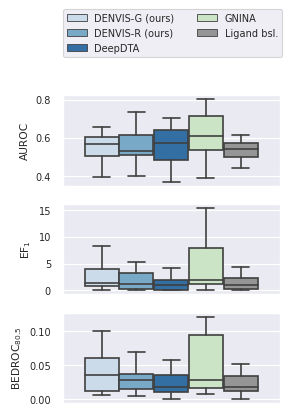

In [29]:
sns.set_context("paper", font_scale=.8, rc={"lines.linewidth": 1.5})
hue_order = ['DENVIS-G', 'DENVIS-R', 'Deep DTA', 'GNINA', 'Ligand bsl.']
color_palette = sns.color_palette("Blues", 3) + sns.color_palette("Greens", 3)[0:1] + sns.color_palette("Greys", 1)
metrics_ = ['AUROC', 'EF1', 'BEDROC80.5']

showfliers = False
linewidth = 1.2

figsize = (2.8,4.)
leg_pos = (-0.02, 2.0)

label_alias = {
    'DENVIS-G': 'DENVIS-G (ours) ',
    'DENVIS-R': 'DENVIS-R (ours)',
    'GNINA': 'GNINA',
    'Vina': 'Vina',
    'RF-score': 'RF-score',
    'NN-score': 'NN-score',
    'Deep DTA': 'DeepDTA',
    'Ligand bsl.': 'Ligand bsl.',
    'Gold': 'Gold',
    'Glide': 'Glide',
    'Surflex': 'Surflex',
    'Flexx': 'FlexX'
}

fig, ax = plt.subplots(figsize=figsize, nrows=3, ncols=1)
for i, metric in enumerate(metrics_):
    sns.boxplot(
        data=results_pt_tf,
        x='Dataset',
        order=[DATASET],
        hue='Model',
        y=metric,
        hue_order=hue_order,
        palette=color_palette,
        showfliers=showfliers,
        linewidth=linewidth,
        ax=ax[i])


# Legend options
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles=handles, labels=[label_alias[l] for l in labels], bbox_to_anchor=leg_pos, loc='upper left', ncol=2)

for ax_ in ax:
    ax_.set_xticklabels([])
    ax_.set_xlabel('')

for ax_ in ax[1:]:
    ax_.legend().remove()

ax[1].set_ylabel(r'EF$_{1}$')
ax[2].set_ylabel(r'BEDROC$_{80.5}$')
plt.show()

## 3.4 One-to-one comparisons (Figure 6)
* DENVIS-R vs. GNINA
* DENVIS-G vs. GNINA

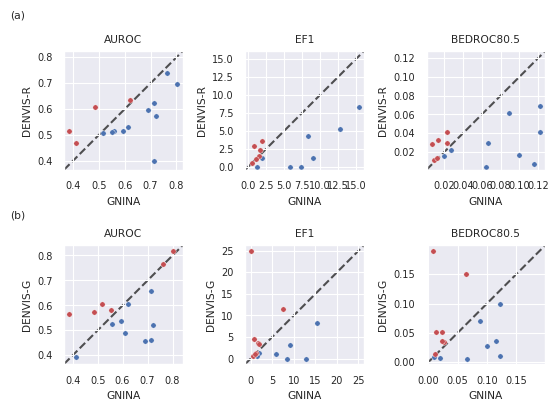

In [18]:
sns.set_context("paper", font_scale=.8, rc={"lines.linewidth": 1.5})
figsize = (5.5,4.)
size = 15

aspect_ratio = 0.7
aspect_ratio = 1.0

# Colors are defined in the cell above, we just index them here
denvis_g_col = color_palette[0]
denvis_r_col = color_palette[1]
gnina_col = color_palette[2]
col_1, col_2 = sns.color_palette('Paired')[8:10]
col_1, col_2 = sns.color_palette(n_colors=4)[0], sns.color_palette(n_colors=4)[3]


fig, ax = plt.subplots(figsize=figsize, nrows=2, ncols=3)
comparisons = [
    ('DENVIS-R', 'GNINA'),
    ('DENVIS-G', 'GNINA')]

for row_id, comparison in enumerate(comparisons):
    for col_id, metric in enumerate(PERFORMANCE_METRICS):
        our_scores = results_pt_tf[(results_pt_tf['Model']==comparison[0])][metric].values
        other_scores = results_pt_tf[(results_pt_tf['Model']==comparison[1])][metric].values
        
        sns.scatterplot(
            x=other_scores[other_scores > our_scores],
            y=our_scores[other_scores > our_scores],
            color=col_1,
            s=size,
            ax=ax[row_id, col_id])
        sns.scatterplot(
            x=other_scores[other_scores < our_scores],
            y=our_scores[other_scores < our_scores],
            color=col_2,
            s=size,
            ax=ax[row_id, col_id])
        plotting_utils.plot_diagonal_line(ax[row_id, col_id])
        ax[row_id, col_id].set_ylabel(comparison[0])
        ax[row_id, col_id].set_xlabel(comparison[1])
        ax[row_id, col_id].set_title(metric)

# Tidy-up
for ax_ in ax.reshape(-1,):
    ax_.set_xticks(ax_.get_yticks()[1:-1])
    ax_.set_yticks(ax_.get_yticks()[1:-1])
          
fig.text(0, 1.0, '(a)')
fig.text(0, 0.5, '(b)')
fig.tight_layout()
plt.show()

## 3.5 Number of targets that one model is better than the other

In [30]:
targets = results_pt_tf['Target'].unique()
for (model_x, model_y) in [('DENVIS-R', 'GNINA'), ('DENVIS-G', 'GNINA')]:
    print(f"Models: {model_x} vs. {model_y}")
    print("----------------------------------------------")
    for metric in ['AUROC', 'EF1', 'BEDROC80.5']:
        x = results_pt_tf[results_pt_tf['Model']==model_x].set_index('Target').reindex(targets)[metric]
        y = results_pt_tf[results_pt_tf['Model']==model_y].set_index('Target').reindex(targets)[metric]
        print(f"{metric}: {model_x} > {model_y}: {(x > y).sum()}")
        print(f"{metric}: {model_y} > {model_x}: {(y > x).sum()}")
    print("----------------------------------------------")

Models: DENVIS-R vs. GNINA
----------------------------------------------
AUROC: DENVIS-R > GNINA: 4
AUROC: GNINA > DENVIS-R: 11
EF1: DENVIS-R > GNINA: 6
EF1: GNINA > DENVIS-R: 8
BEDROC80.5: DENVIS-R > GNINA: 6
BEDROC80.5: GNINA > DENVIS-R: 9
----------------------------------------------
Models: DENVIS-G vs. GNINA
----------------------------------------------
AUROC: DENVIS-G > GNINA: 6
AUROC: GNINA > DENVIS-G: 9
EF1: DENVIS-G > GNINA: 8
EF1: GNINA > DENVIS-G: 7
BEDROC80.5: DENVIS-G > GNINA: 7
BEDROC80.5: GNINA > DENVIS-G: 8
----------------------------------------------


## 3.6 Table per-target comparisons (Tables S4, S5, S6)

In [24]:
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 120
pd.set_option('display.expand_frame_repr', False) 

perf_metrics = ['AUROC', 'EF1', 'BEDROC80.5']
columns_order = ['DENVIS-G', 'DENVIS-R', 'GNINA', 'Deep DTA', 'Ligand bsl.']
columns_alias = {
    'DENVIS-G': 'D-G',
    'DENVIS-R': 'D-R',
    'GNINA': 'GNINA',
    'Deep DTA': 'DDTA',
    'Ligand bsl.': 'Bsl.'}

for metric in perf_metrics:
    print_df = pd.pivot(results_pt_tf, index='Target', columns='Model', values=metric)
    print_df.columns.name, print_df.index.name = None, None
    print_df = print_df[columns_order].rename(columns=columns_alias)
    print(metric)
    print('--------------------------------------')
    print(print_df)
    print('\n')

AUROC
--------------------------------------
          D-G  D-R  GNINA  DDTA  Bsl.
ADRB2    0.60 0.51   0.52  0.37  0.45
ALDH1    0.54 0.52   0.60  0.58  0.55
ESR1_ago 0.66 0.62   0.71  0.66  0.61
ESR1_ant 0.52 0.57   0.72  0.63  0.57
FEN1     0.58 0.51   0.55  0.49  0.54
GBA      0.46 0.40   0.71  0.55  0.51
IDH1     0.46 0.60   0.69  0.70  0.54
KAT2A    0.39 0.47   0.41  0.48  0.49
MAPK1    0.61 0.64   0.62  0.58  0.51
MTORC1   0.57 0.61   0.49  0.47  0.50
OPRK1    0.82 0.70   0.80  0.69  0.76
PKM2     0.49 0.53   0.61  0.57  0.51
PPARG    0.76 0.74   0.76  0.68  0.59
TP53     0.52 0.52   0.56  0.57  0.58
VDR      0.57 0.52   0.39  0.42  0.44


EF1
--------------------------------------
           D-G  D-R  GNINA  DDTA  Bsl.
ADRB2    25.00 0.00   0.00  0.00  0.00
ALDH1     1.38 1.20   1.88  1.42  0.93
ESR1_ago  8.33 8.33  15.38  0.00  0.00
ESR1_ant  0.99 0.00   5.88  0.00  0.00
FEN1      3.26 3.53   1.90  0.27  3.26
GBA       3.03 1.21   9.04  4.22  1.82
IDH1      0.00 5.26  12.82  5